## Data preprocessing and Hyper parameter tuning of XGBoost Model

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [14]:
df = pd.read_csv("train_combined.csv")

In [15]:
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory,BMI,BMIxGender
0,0.0,Male,24.443011,1.699998,81.669950,yes,yes,2,3,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565,28.259565
1,1.0,Female,18.000000,1.560000,57.000000,yes,yes,2,3,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091,0.000000
2,2.0,Female,18.000000,1.711460,50.165754,yes,yes,2,1,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706,0.000000
3,3.0,Female,20.952737,1.710730,131.274851,yes,yes,3,3,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798,0.000000
4,4.0,Male,31.641081,1.914186,93.798055,yes,yes,3,2,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151,25.599151


In [16]:
test_df = pd.read_csv('test_final.csv')
test_ids = test_df['id']

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17644 entries, 0 to 17643
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15533 non-null  float64
 1   Gender                          17644 non-null  object 
 2   Age                             17644 non-null  float64
 3   Height                          17644 non-null  float64
 4   Weight                          17644 non-null  float64
 5   family_history_with_overweight  17644 non-null  object 
 6   FAVC                            17644 non-null  object 
 7   FCVC                            17644 non-null  int64  
 8   NCP                             17644 non-null  int64  
 9   CAEC                            17644 non-null  object 
 10  SMOKE                           17644 non-null  object 
 11  CH2O                            17644 non-null  float64
 12  SCC                             

In [18]:
numeric_features = [
    'Age', 'Height', 'Weight', 'BMI'      
    , 'BMIxGender', 'CH2O', 'FAF', 'TUE'
]

categorical_features = [
    'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'FCVC', 'NCP',
      'CALC', 'MTRANS', 'SCC','SMOKE'
    	
]

In [19]:
le = LabelEncoder()
y = le.fit_transform(df['WeightCategory'])

In [20]:
X = df[numeric_features + categorical_features]
X_test_submission = test_df[numeric_features + categorical_features]
X.shape

(17644, 18)

In [21]:
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numeric_features),
                                               ('cat', OneHotEncoder(), categorical_features)], remainder='passthrough')

In [22]:
preprocessor.fit(X)

X_train_processed_array = preprocessor.transform(X)
X_test_processed_array = preprocessor.transform(X_test_submission)

feature_names = preprocessor.get_feature_names_out()

X_train_processed = pd.DataFrame(X_train_processed_array, columns=feature_names, index=X.index)
X_test_processed = pd.DataFrame(X_test_processed_array, columns=feature_names, index=X_test_submission.index)

In [23]:
X_train_processed.head()

,num__Age,num__Height,num__Weight,num__BMI,num__BMIxGender,num__CH2O,num__FAF,num__TUE,cat__Gender_Female,cat__Gender_Male,...,cat__CALC_no,cat__MTRANS_Automobile,cat__MTRANS_Bike,cat__MTRANS_Motorbike,cat__MTRANS_Public_Transportation,cat__MTRANS_Walking,cat__SCC_no,cat__SCC_yes,cat__SMOKE_no,cat__SMOKE_yes
0,0.098647,-0.001479,-0.226640,-0.228618,0.875248,1.213584,-1.169866,0.592524,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-1.021675,-1.585889,-1.162906,-0.812832,-0.957400,-0.041553,0.022712,0.631530,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-1.021675,0.128241,-1.422277,-1.573115,-0.957400,-0.188871,-0.137040,1.748281,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.508248,0.119979,1.655949,1.775683,-0.957400,-0.577321,0.580675,0.267117,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.350261,2.422567,0.233642,-0.549911,0.702719,-0.074679,1.177095,0.518329,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [24]:
X_test_processed.head()

,num__Age,num__Height,num__Weight,num__BMI,num__BMIxGender,num__CH2O,num__FAF,num__TUE,cat__Gender_Female,cat__Gender_Male,...,cat__CALC_no,cat__MTRANS_Automobile,cat__MTRANS_Bike,cat__MTRANS_Motorbike,cat__MTRANS_Public_Transportation,cat__MTRANS_Walking,cat__SCC_no,cat__SCC_yes,cat__SMOKE_no,cat__SMOKE_yes
0,-0.846545,0.818476,1.905586,1.657849,-0.957400,-0.029475,0.578371,0.321888,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.400549,-0.020175,-0.479776,-0.501244,-0.957400,-0.041553,0.711812,2.067046,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.276587,0.422414,-0.214114,-0.360972,0.804176,-0.319985,-0.632002,-1.026394,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.224257,0.853911,1.260703,0.988262,1.528692,0.195754,-0.319884,-0.860522,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-1.021675,-0.340977,-0.859292,-0.826770,-0.957400,-0.041553,0.022712,0.631530,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [25]:
X_train_processed['BMI_sq'] = X_train_processed['num__BMI'] ** 2

In [26]:
X_test_processed['BMI_sq'] = X_test_processed['num__BMI'] ** 2

In [27]:
# Set up 5-Fold Cross-Validation
k_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [30]:
# XGBoost model
model_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),  
    random_state=42,
    
    n_jobs=-1,
    device='cuda',        
    tree_method='hist'    
)

**Grid 1**

In [55]:
# Hyperparameter Tuning Grid 1
param_grid_1 = {
    'n_estimators': [400,500, 800, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 3, 5]
    }

In [56]:
#  GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_1,
    cv=k_folds,
    scoring='accuracy',
    n_jobs=1,  
    verbose=2
)

In [62]:
grid_search_xgb.fit(X_train_processed, y)

results_df = pd.DataFrame(grid_search_xgb.cv_results_)

print(f"Best XGBoost CV Accuracy: {grid_search_xgb.best_score_ * 100:.3f}%")
print(f"Best XGBoost Parameters: {grid_search_xgb.best_params_}")

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400; total time=  36.2s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400; total time=  37.7s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400; total time=  39.8s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400; total time=  27.0s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400; total time=   6.8s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=500; total time=   7.8s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=500; total time=   7.5s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=500; total time=   7.6s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=500; total time=   8.7s
[CV] END learning_rate=0.01, max_depth=4, min_

In [63]:
heatmap_data = pd.pivot_table(results_df, values='mean_test_score', index='param_max_depth', columns='param_learning_rate')

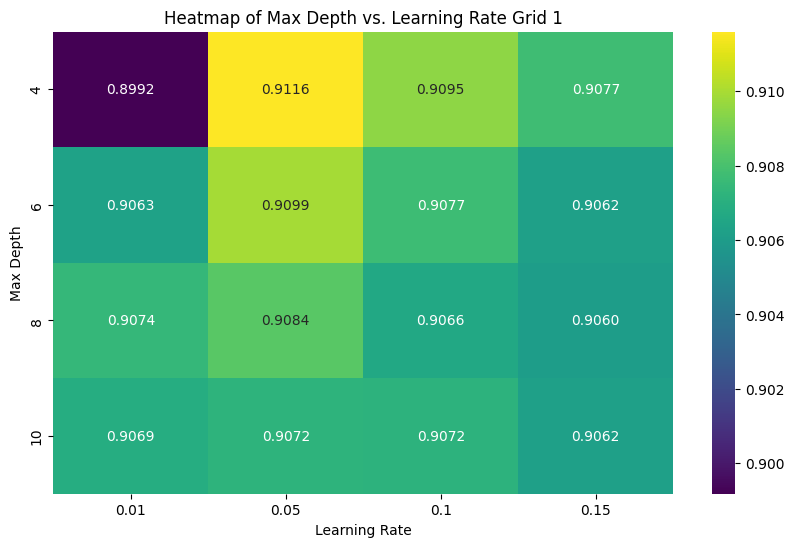

In [95]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data,annot=True,fmt=".4f",cmap="viridis")
plt.title('Heatmap of Max Depth vs. Learning Rate Grid 1')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.show()

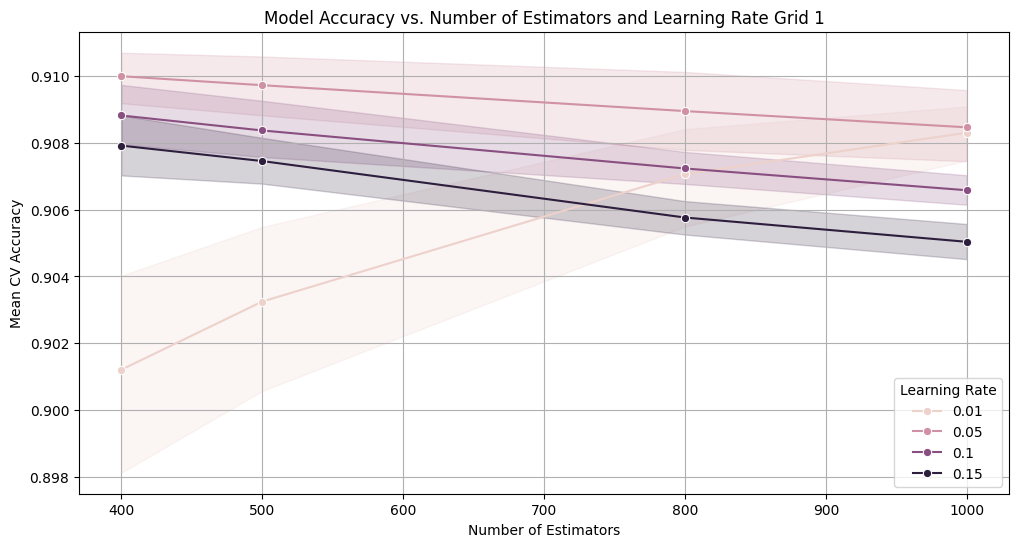

In [96]:
plt.figure(figsize=(12, 6))
sns.lineplot(
        data=results_df,
        x='param_n_estimators',
        y='mean_test_score',
        hue='param_learning_rate', 
        marker='o'
    )
plt.title('Model Accuracy vs. Number of Estimators and Learning Rate Grid 1')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show() 

**Grid 2**

In [67]:
# Hyperparameter Tuning Grid 2
param_grid_2 = {
    'n_estimators': [1000,1200,1500],
    'learning_rate': [0.02,0.04, 0.05,0.06],
    'max_depth': [3,4,5],
    'min_child_weight': [1,2]
    }

In [68]:
# GridSearchCV
grid_search_xgb2 = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_2,
    cv=k_folds,
    scoring='accuracy',
    n_jobs=1,  
    verbose=2
)

In [69]:
grid_search_xgb2.fit(X_train_processed, y)

results_df2 = pd.DataFrame(grid_search_xgb2.cv_results_)

print(f"Best XGBoost CV Accuracy: {grid_search_xgb2.best_score_ * 100:.3f}%")
print(f"Best XGBoost Parameters: {grid_search_xgb2.best_params_}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1000; total time= 1.1min
[CV] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1000; total time= 1.2min
[CV] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1000; total time= 1.1min
[CV] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1000; total time= 1.2min
[CV] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1000; total time= 1.2min
[CV] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1200; total time= 1.4min
[CV] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1200; total time= 1.3min
[CV] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1200; total time= 1.4min
[CV] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1200; total time= 1.5min
[CV] END learning_rate=0.02, max_depth

In [70]:
heatmap_data2 = pd.pivot_table(results_df2, values='mean_test_score', index='param_max_depth', columns='param_learning_rate')

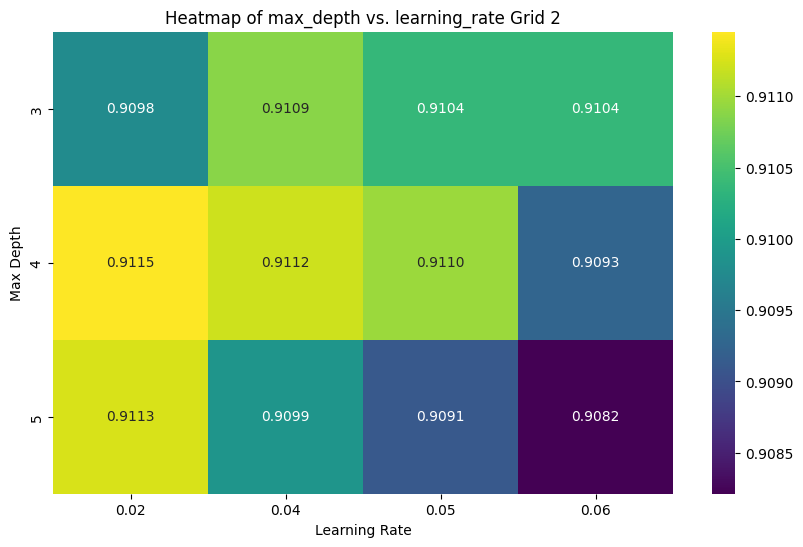

In [97]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data2,annot=True,fmt=".4f",cmap="viridis")
plt.title('Heatmap of max_depth vs. learning_rate Grid 2')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.show()

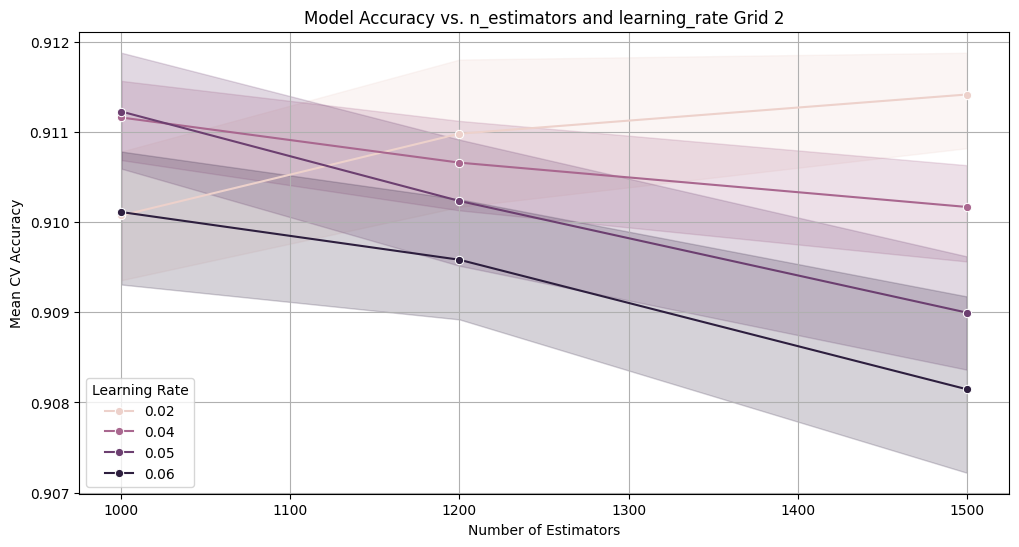

In [98]:
plt.figure(figsize=(12, 6))
sns.lineplot(
        data=results_df2,
        x='param_n_estimators',
        y='mean_test_score',
        hue='param_learning_rate', 
        marker='o'
    )
plt.title('Model Accuracy vs. n_estimators and learning_rate Grid 2')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show() 

**Grid 3**

In [78]:
# Hyperparameter Tuning Grid 3 finetuning
param_grid_3 = {
    'n_estimators': [925,950,975],
    'learning_rate': [0.425,0.045,0.475],
    'max_depth': [4],
    'min_child_weight': [1]
    }

In [79]:
# GridSearchCV
grid_search_xgb3 = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_3,
    cv=k_folds,
    scoring='accuracy',
    n_jobs=1,  
    verbose=2
)

In [80]:
grid_search_xgb3.fit(X_train_processed, y)

results_df3 = pd.DataFrame(grid_search_xgb3.cv_results_)

print(f"Best XGBoost CV Accuracy: {grid_search_xgb3.best_score_ * 100:.3f}%")
print(f"Best XGBoost Parameters: {grid_search_xgb3.best_params_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END learning_rate=0.425, max_depth=4, min_child_weight=1, n_estimators=925; total time=  14.0s
[CV] END learning_rate=0.425, max_depth=4, min_child_weight=1, n_estimators=925; total time=   8.2s
[CV] END learning_rate=0.425, max_depth=4, min_child_weight=1, n_estimators=925; total time=   8.0s
[CV] END learning_rate=0.425, max_depth=4, min_child_weight=1, n_estimators=925; total time=   7.8s
[CV] END learning_rate=0.425, max_depth=4, min_child_weight=1, n_estimators=925; total time=   7.8s
[CV] END learning_rate=0.425, max_depth=4, min_child_weight=1, n_estimators=950; total time=   7.8s
[CV] END learning_rate=0.425, max_depth=4, min_child_weight=1, n_estimators=950; total time=   8.1s
[CV] END learning_rate=0.425, max_depth=4, min_child_weight=1, n_estimators=950; total time=   7.8s
[CV] END learning_rate=0.425, max_depth=4, min_child_weight=1, n_estimators=950; total time=   8.0s
[CV] END learning_rate=0.425, max_depth=

In [122]:
heatmap_data3 = pd.pivot_table(results_df3, values='mean_test_score', index='param_n_estimators', columns='param_learning_rate')

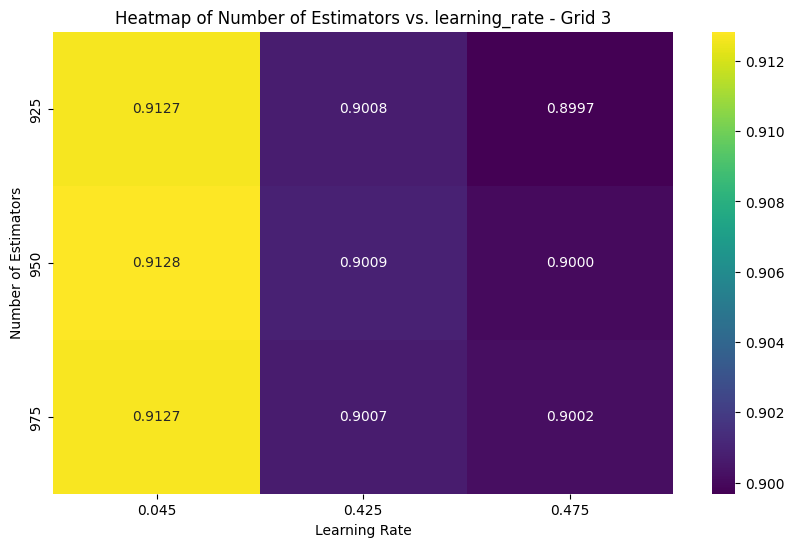

In [123]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data3,annot=True,fmt=".4f",cmap="viridis")
plt.title('Heatmap of Number of Estimators vs. learning_rate - Grid 3')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Estimators')
plt.show()

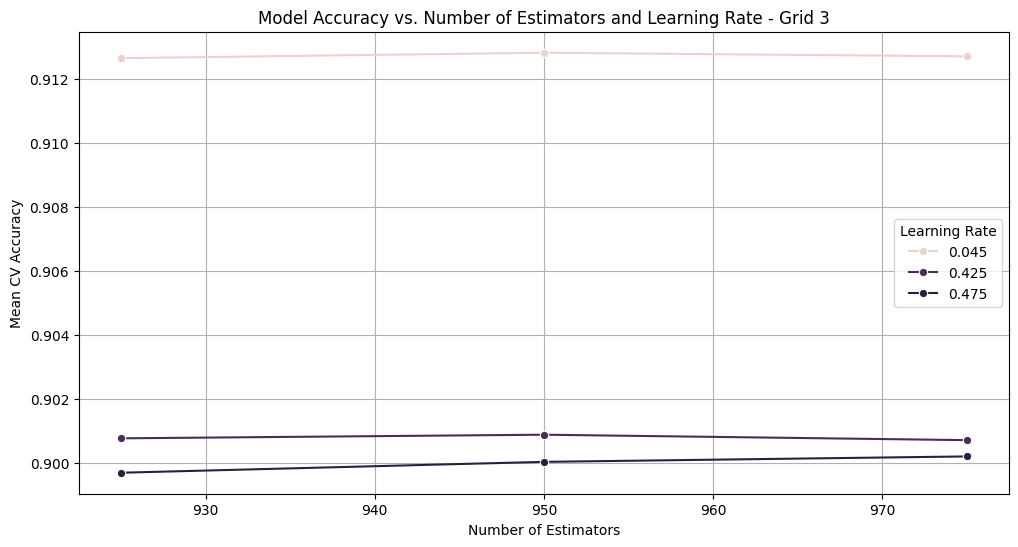

In [100]:
plt.figure(figsize=(12, 6))
sns.lineplot(
        data=results_df3,
        x='param_n_estimators',
        y='mean_test_score',
        hue='param_learning_rate', 
        marker='o'
    )
plt.title('Model Accuracy vs. Number of Estimators and Learning Rate - Grid 3')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show() 

**Grid 4**

In [82]:
# Hyperparameter Tuning Grid 4 for subsample, gamma etc
param_grid_4 = {
    'n_estimators': [950],
    'learning_rate': [0.045],
    'max_depth': [4],
    'min_child_weight': [1],

    'subsample': [0.7, 0.8, 0.9],         
    'colsample_bytree': [0.7, 0.8, 0.9],  
    'gamma': [0, 0.1, 0.2]
    }

In [83]:
# GridSearchCV
grid_search_xgb4 = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_4,
    cv=k_folds,
    scoring='accuracy',
    n_jobs=1,  
    verbose=2
)

In [84]:
grid_search_xgb4.fit(X_train_processed, y)

results_df4 = pd.DataFrame(grid_search_xgb4.cv_results_)

print(f"Best XGBoost CV Accuracy: {grid_search_xgb4.best_score_ * 100:.3f}%")
print(f"Best XGBoost Parameters: {grid_search_xgb4.best_params_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, subsample=0.7; total time=  13.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, subsample=0.7; total time=   8.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, subsample=0.7; total time=   9.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, subsample=0.7; total time=   9.5s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, subsample=0.7; total time=   9.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, subsample=0.8; total time=  10.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.045, m

In [105]:
results_df4.columns


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_colsample_bytree', 'param_gamma', 'param_learning_rate',
       'param_max_depth', 'param_min_child_weight', 'param_n_estimators',
       'param_subsample', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [106]:
heatmap_data4 = pd.pivot_table(results_df4, values='mean_test_score', index='param_colsample_bytree', columns='param_subsample')

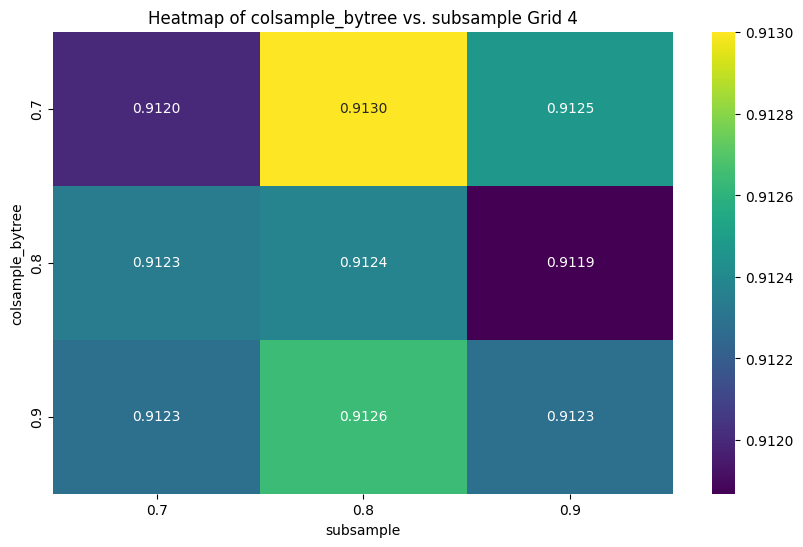

In [107]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data4,annot=True,fmt=".4f",cmap="viridis")
plt.title('Heatmap of colsample_bytree vs. subsample Grid 4')
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.show()

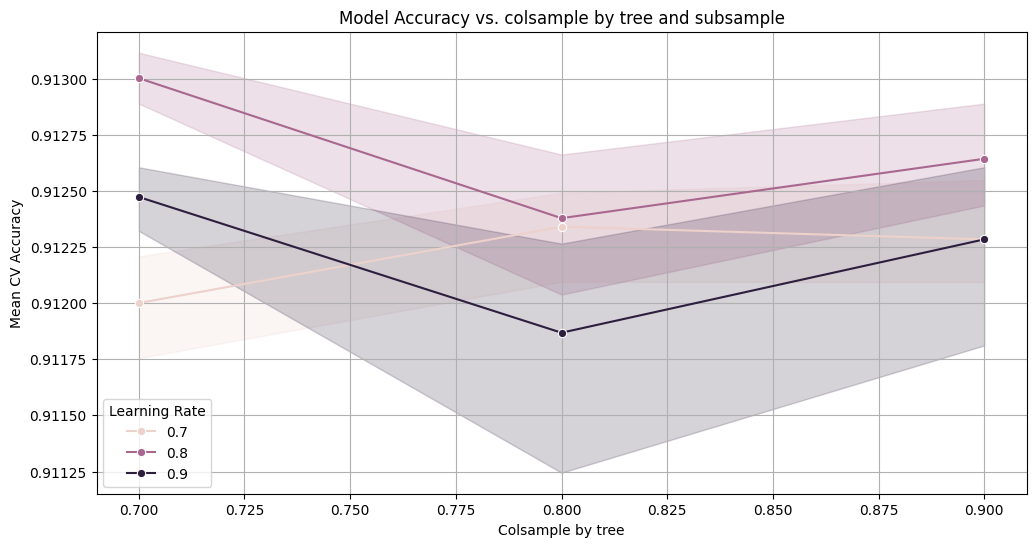

In [109]:
plt.figure(figsize=(12, 6))
sns.lineplot(
        data=results_df4,
        x='param_colsample_bytree',
        y='mean_test_score',
        hue='param_subsample', 
        marker='o'
    )
plt.title('Model Accuracy vs. colsample by tree and subsample')
plt.xlabel('Colsample by tree')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show() 

**Grid 5 L1 l2 regularization**

In [89]:
# Hyperparameter Tuning Grid  L1, L2 regularization 
param_grid_5 = {
    'n_estimators': [950],
    'learning_rate': [0.045],
    'max_depth': [4],
    'min_child_weight': [1],
    'subsample': [0.7],         
    'colsample_bytree': [ 0.8],  
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 0.5],
    'reg_lambda': [0.5, 1, 1.5, 2]
    }

In [90]:
# GridSearchCV
grid_search_xgb5 = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_5,
    cv=k_folds,
    scoring='accuracy',
    n_jobs=1,  
    verbose=2
)

In [91]:
grid_search_xgb5.fit(X_train_processed, y)

results_df5 = pd.DataFrame(grid_search_xgb5.cv_results_)

print(f"Best XGBoost CV Accuracy: {grid_search_xgb5.best_score_ * 100:.3f}%")
print(f"Best XGBoost Parameters: {grid_search_xgb5.best_params_}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=  13.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=   9.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=   9.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=   9.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=   9.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.045, ma

In [112]:
heatmap_data5 = pd.pivot_table(results_df5, values='mean_test_score', index='param_reg_alpha', columns='param_reg_lambda')

In [113]:
results_df5.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_colsample_bytree', 'param_gamma', 'param_learning_rate',
       'param_max_depth', 'param_min_child_weight', 'param_n_estimators',
       'param_reg_alpha', 'param_reg_lambda', 'param_subsample', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

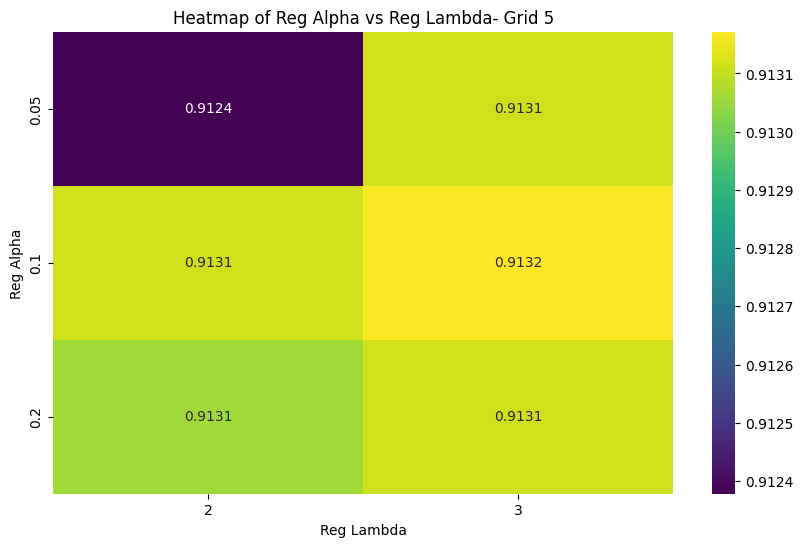

In [114]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data5,annot=True,fmt=".4f",cmap="viridis")
plt.title('Heatmap of Reg Alpha vs Reg Lambda- Grid 5')
plt.xlabel('Reg Lambda')
plt.ylabel('Reg Alpha')
plt.show()

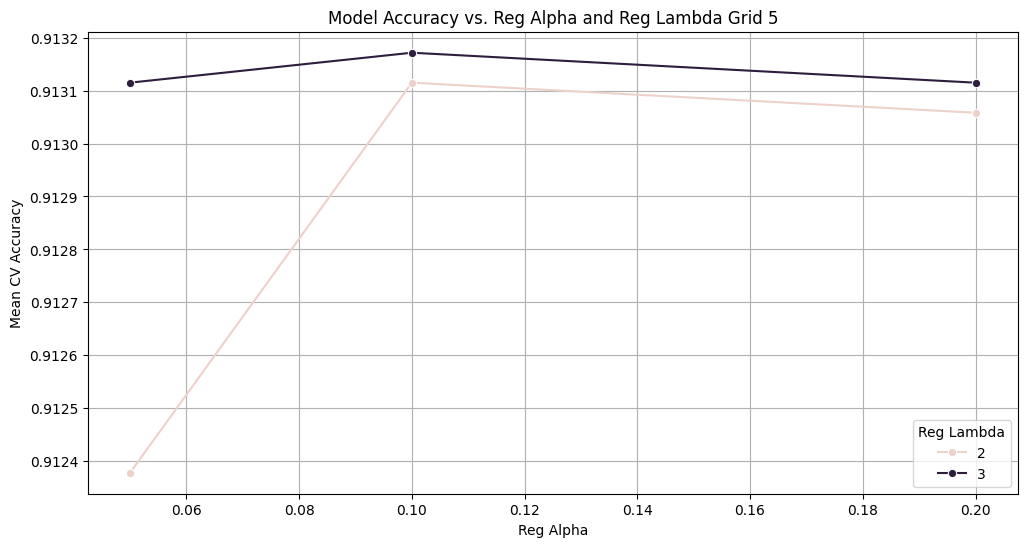

In [115]:
plt.figure(figsize=(12, 6))
sns.lineplot(
        data=results_df5,
        x='param_reg_alpha',
        y='mean_test_score',
        hue='param_reg_lambda', 
        marker='o'
    )
plt.title('Model Accuracy vs. Reg Alpha and Reg Lambda Grid 5')
plt.xlabel('Reg Alpha')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Reg Lambda')
plt.grid(True)
plt.show() 

**Grid 6 Fine tuning L1 L2**

In [1]:
# Hyperparameter Tuning Grid  L1, L2 regularization fine tuning
param_grid_6 = {
    'n_estimators': [950],
    'learning_rate': [0.045],
    'max_depth': [4],
    'min_child_weight': [1],
    'subsample': [0.6,0.7,0.75],         
    'colsample_bytree': [ 0.75,0.8,0.85],  
    'gamma': [0.1],
    'reg_alpha': [0.1],
    'reg_lambda': [4]
    }

In [31]:
# GridSearchCV
grid_search_xgb6 = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_6,
    cv=k_folds,
    scoring='accuracy',
    n_jobs=1,  
    verbose=2
)

In [126]:
grid_search_xgb6.fit(X_train_processed, y)

results_df5 = pd.DataFrame(grid_search_xgb6.cv_results_)

print(f"Best XGBoost CV Accuracy: {grid_search_xgb6.best_score_ * 100:.3f}%")
print(f"Best XGBoost Parameters: {grid_search_xgb6.best_params_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, reg_alpha=0.075, reg_lambda=4, subsample=0.7; total time=  12.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, reg_alpha=0.075, reg_lambda=4, subsample=0.7; total time=   9.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, reg_alpha=0.075, reg_lambda=4, subsample=0.7; total time=   9.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, reg_alpha=0.075, reg_lambda=4, subsample=0.7; total time=   8.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.045, max_depth=4, min_child_weight=1, n_estimators=950, reg_alpha=0.075, reg_lambda=4, subsample=0.7; total time=   8.8s
[CV] END colsample_bytree=0.8, gamma=0.1, lea

In [ ]:
# Submission file without regularization best model
best_model1 = grid_search_xgb4.best_estimator_
predictions_numeric1 = best_model1.predict(X_test_processed)
predictions_labels1 = le.inverse_transform(predictions_numeric1)

In [137]:
submission_df1 = pd.DataFrame({
    'id': test_ids,
    'NObeyesdad': predictions_labels1})

In [138]:
submission_df1.to_csv('submission_XGB1_regul.csv', index=False)

**Plotting Tuning Stages**

In [127]:
stages = [
    'Grid 1: Broad Search',
    'Grid 2: Refined Search',
    'Grid 3: Fine-Tuning',
    'Grid 4: Stochastic Params',
    'Grid 5: L1/L2 ',
    'Grid 6: L1/L2(Final) '
]
accuracies = [91.249,91.249,91.283,91.311,91.311,91.391]
 

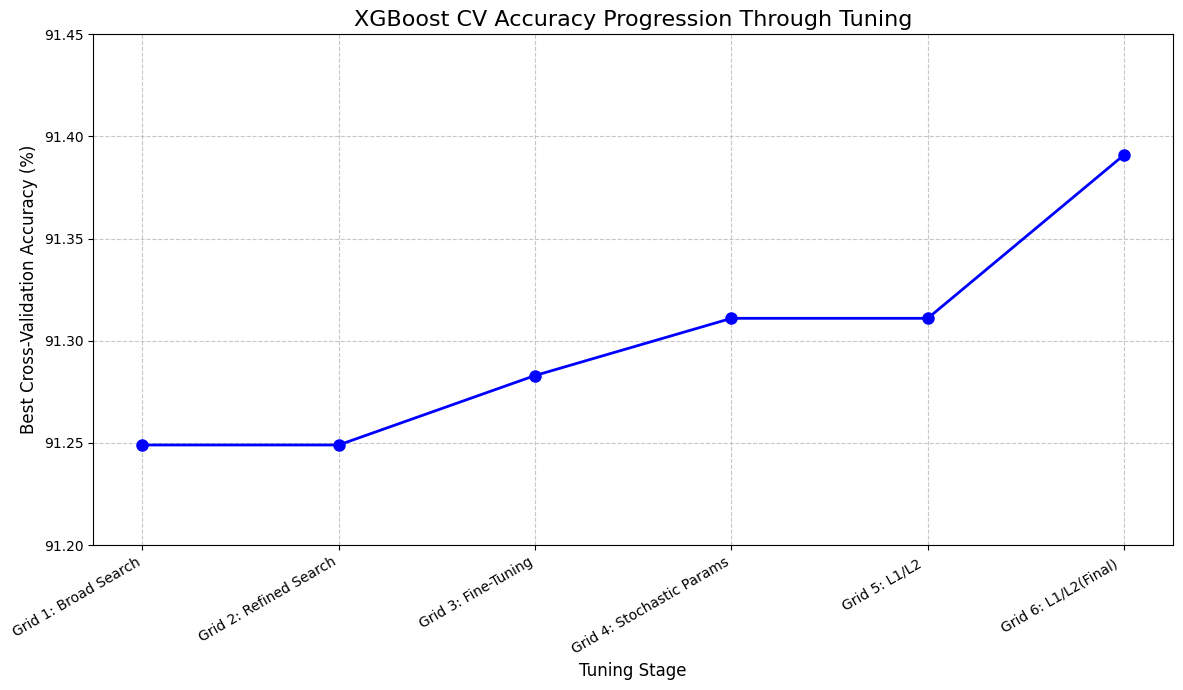

In [129]:
plt.figure(figsize=(12, 7)) 
plt.plot(stages, accuracies, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

plt.title('XGBoost CV Accuracy Progression Through Tuning', fontsize=16)
plt.xlabel('Tuning Stage', fontsize=12)
plt.ylabel('Best Cross-Validation Accuracy (%)', fontsize=12)


plt.ylim(91.2, 91.45)
plt.xticks(rotation=30, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()